In [112]:
import pandas as pd 
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn import preprocessing

In [113]:
totals = pd.read_csv("./totals.csv")
shooting = pd.read_csv("./shooting.csv")

In [114]:
#add average shot distance to data
data = totals.copy()
data["Distance"] = shooting["Dist."]
data.index = data.Player.values
data.columns

Index(['Season', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'Distance'],
      dtype='object')

In [115]:
#I'm looking at what a player does, not how good they are at doing, so I'm going to drop the percentage stats and unrelated columns


del(data["Season"])
del(data["Player"])
del(data["Pos"])
del(data["Age"])
del(data["FG%"])
del(data["3P%"])
del(data["2P%"])
del(data["eFG%"])
del(data["FT%"])


In [116]:
#I'm only interseted in offensive stats so I'm dropping defensive stats

del(data["DRB"])
del(data["TRB"])
del(data["STL"])
del(data["BLK"])
del(data["PF"])


In [117]:
del(data["Tm"])

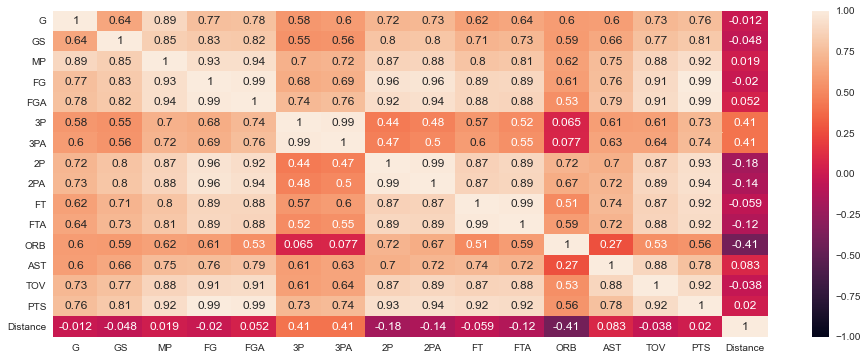

In [118]:
#Select stats, don't want to get correlated stats
def corrmap(df):
    corrs = df.corr()
    plt.figure(figsize=(16, 6))
    heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)

corrmap(data)

In [ ]:
#Going to drop FG and FGA
#Going to drop 3PA
#Going to drop 2PA
#Going to drop FTA
#TOV and AST are highly correlated, I'm going to keep asists 
#Dropping points

In [163]:
key_features = data[["3PA" , "2PA" , "ORB" , "AST" ,  "FTA" , "Distance"]]

In [164]:
#First going to scale everything to per game

for c in key_features.columns:
    key_features[c] = key_features[c] / data["G"]

In [21]:
#I'm going to scale 3P, 2P, ORB, AST, and FT with Min max and Distance with standard scaler. This is because I plan on converting 3P, 2P, ORB, AST, and FT into percentages
#I want a player that has 1 3P, 1 2P, 1 ORB, 1 AST, and 1 FT to be in the same category as one with 2 3P, 2 2P, 2 ORB, 2 AST, and 2 FT

,3P,2P,ORB,AST,Distance,FT
A.J. Price,1.228070,1.596491,0.350877,3.596491,0.321053,0.859649
Aaron Brooks,0.285714,0.285714,0.142857,0.857143,2.614286,0.000000
Aaron Brooks,1.043478,1.978261,0.260870,2.347826,0.341304,0.869565
Aaron Brooks,0.943396,1.754717,0.245283,2.150943,0.298113,0.754717
Aaron Gray,0.000000,1.142857,1.142857,0.785714,0.092857,0.547619
...,...,...,...,...,...,...
Yogi Ferrell,1.500000,2.500000,1.500000,2.500000,8.700000,0.000000
Yuta Watanabe,0.800000,0.400000,0.866667,0.400000,1.066667,0.533333
Zach LaVine,3.526316,5.684211,0.526316,5.105263,0.831579,4.684211
Zeke Nnaji,0.000000,0.333333,0.222222,0.000000,1.222222,0.000000


In [165]:
minMaxData = key_features[["3PA" , "2PA" , "ORB" , "AST" , "FTA"]]
MMScaler = MinMaxScaler()
X = MMScaler.fit_transform(minMaxData)


In [166]:
for i in range(len(X)):
    total = X[i].sum()
    for j in range(len(X[i])):
        X[i][j] = X[i][j]/total 


In [168]:
scaled = pd.DataFrame(X , columns = ["3PA" , "2PA" , "ORB" , "AST" , "FTA"], index = totals.Player.values)

In [169]:
scaled["Distance"] = data["Distance"]

<AxesSubplot:xlabel='MP', ylabel='Density'>

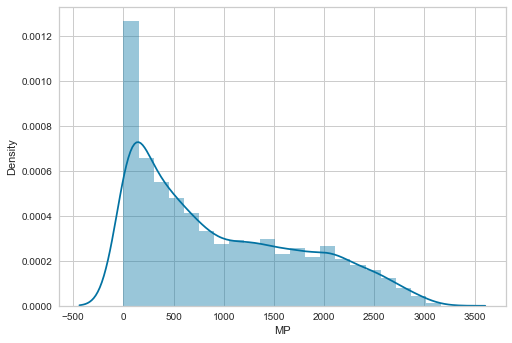

In [170]:
sns.distplot(totals["MP"])

In [171]:
#Remove every player with less than 250 minutes played
meets_requirement = data["MP"] >= 250
selected = scaled.loc[meets_requirement, :]

2 clusters has score: 0.6043864137708886
3 clusters has score: 0.5545913011468223
4 clusters has score: 0.5323946686601464
5 clusters has score: 0.5260853195993032
6 clusters has score: 0.5249407598757608


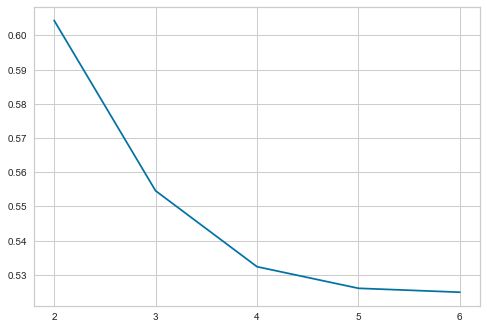

In [172]:
def sillhoutte(data):
    pts = []
    for k in range(2,7):
        kmeans = KMeans(n_clusters=k).fit(data)
        labels = kmeans.labels_
        #print(labels)
        #data["pos"] = labels
        pts.append(silhouette_score(data,labels))
        print(f"{k} clusters has score:" , silhouette_score(data,labels))
    plt.plot(range(2,7) , pts)
    plt.xticks(range(2,7))
    plt.show()
sillhoutte(selected)

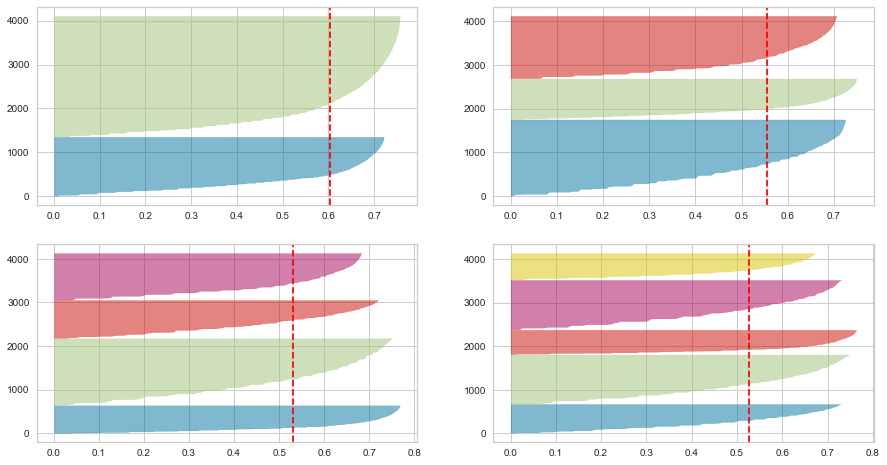

In [128]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(selected)
    

In [77]:
#5 clusters seems best as even though two has a better score, 5 is more realistic and the silhouette scores are comparable

In [212]:
kmean = KMeans(n_clusters = 5).fit(selected)
new_pos = kmean.labels_
centers = kmean.cluster_centers_

In [213]:
visual = pd.DataFrame(centers , columns = ["3PA" , "2PA" , "ORB" , "AST" , "FTA" , "Distance"])
visual

,3PA,2PA,ORB,AST,FTA,Distance
0,0.070055,0.330417,0.247764,0.158370,0.193394,8.995152
1,0.291608,0.243170,0.107626,0.200293,0.157302,15.976032
2,0.008883,0.292863,0.393643,0.098371,0.206240,4.329273
3,0.422789,0.176538,0.095894,0.186527,0.118252,19.387994
4,0.191100,0.287690,0.144727,0.197532,0.178951,12.901083


In [214]:
comparision = totals.copy()
comparision = comparision[comparision["MP"]>=250]
comparision["new_pos"] = new_pos

In [215]:
#slimming down the number of positions and removing duplicate positions I.E : SG-PG and PG-SG
positions = comparision["Pos"].values
revised = []
for pos in positions:
    if pos == "C":
        revised.append(pos)
    elif pos == "PG":
        revised.append(pos)
    elif pos == "SG":
        revised.append(pos)
    elif pos == "PF":
        revised.append(pos)
    elif pos == "SF":
        revised.append(pos)
    
    elif pos == "PG-SG" or pos == "SG-PG":
        revised.append(pos[0:2])
    elif pos == "SF-SG" or pos == "SG-SF":
        revised.append(pos[0:2])
    elif pos == "PF-C" or pos == "C-PF":
        revised.append("PF-C")

    else:
        char = pos[0:1]
        if char == "C":
            revised.append("C")
        else:
            revised.append(pos[0:2]) 
comparision["Pos"] = revised

Text(0, 0.5, 'Old Position Count')

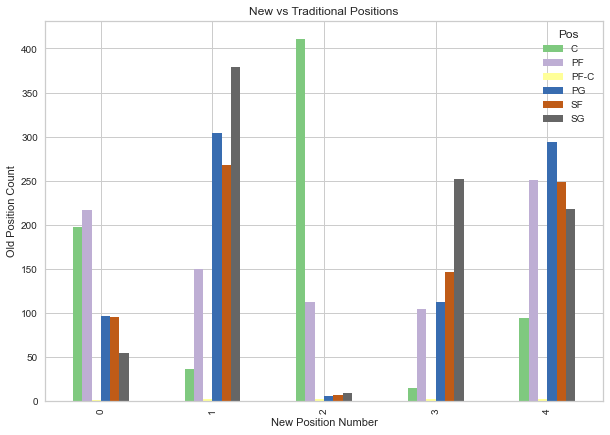

In [219]:
new_vs_old = comparision[["Pos" , "new_pos"]].groupby(["new_pos" , "Pos"]).size().unstack()
new_vs_old.plot(kind = "bar" , colormap = "Accent" , figsize = (10,7))
plt.title("New vs Traditional Positions")
plt.xlabel("New Position Number")
plt.ylabel("Old Position Count")